In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import spinesTS
spinesTS.__version__

'0.3.4'

In [3]:
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score

In [4]:
from spinesTS.data import BuiltInSeriesData
from spinesTS.nn import *
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error

In [5]:
series_data = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [6]:
cs = series_data['Electric_Production']

x_train, x_test, y_train, y_test = split_series(cs['value'], cs['value'], 128, 24, train_size=0.9)

In [7]:
x_train.shape, x_test.shape

((221, 128), (25, 128))

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler2 = MinMaxScaler()
y_train = scaler2.fit_transform(y_train)
y_test = scaler2.transform(y_test)

# StackingRNN

Using cpu backend
Epoch 1/3000  
7/7 - p0 - loss: 0.1653 - mae: 0.2087 - val_loss: 0.1646 - val_mae: 0.1646 - 0.21s/epoch - 0.030s/step
Epoch 2/3000  
7/7 - p1 - loss: 0.2092 - mae: 0.1933 - val_loss: 0.1886 - val_mae: 0.1886 - 0.19s/epoch - 0.027s/step
Epoch 3/3000  
7/7 - p0 - loss: 0.1630 - mae: 0.1628 - val_loss: 0.1612 - val_mae: 0.1612 - 0.18s/epoch - 0.026s/step
Epoch 4/3000  
7/7 - p1 - loss: 0.1721 - mae: 0.1772 - val_loss: 0.1688 - val_mae: 0.1688 - 0.17s/epoch - 0.025s/step
Epoch 5/3000  
7/7 - p2 - loss: 0.1567 - mae: 0.1587 - val_loss: 0.1700 - val_mae: 0.1700 - 0.17s/epoch - 0.025s/step
Epoch 6/3000  
7/7 - p3 - loss: 0.1592 - mae: 0.1502 - val_loss: 0.1614 - val_mae: 0.1614 - 0.18s/epoch - 0.025s/step
Epoch 7/3000  
7/7 - p4 - loss: 0.1658 - mae: 0.1611 - val_loss: 0.1738 - val_mae: 0.1738 - 0.18s/epoch - 0.025s/step
Epoch 8/3000  
7/7 - p5 - loss: 0.1610 - mae: 0.1538 - val_loss: 0.1627 - val_mae: 0.1627 - 0.18s/epoch - 0.026s/step
Epoch 9/3000  
7/7 - p0 - loss: 0.1559

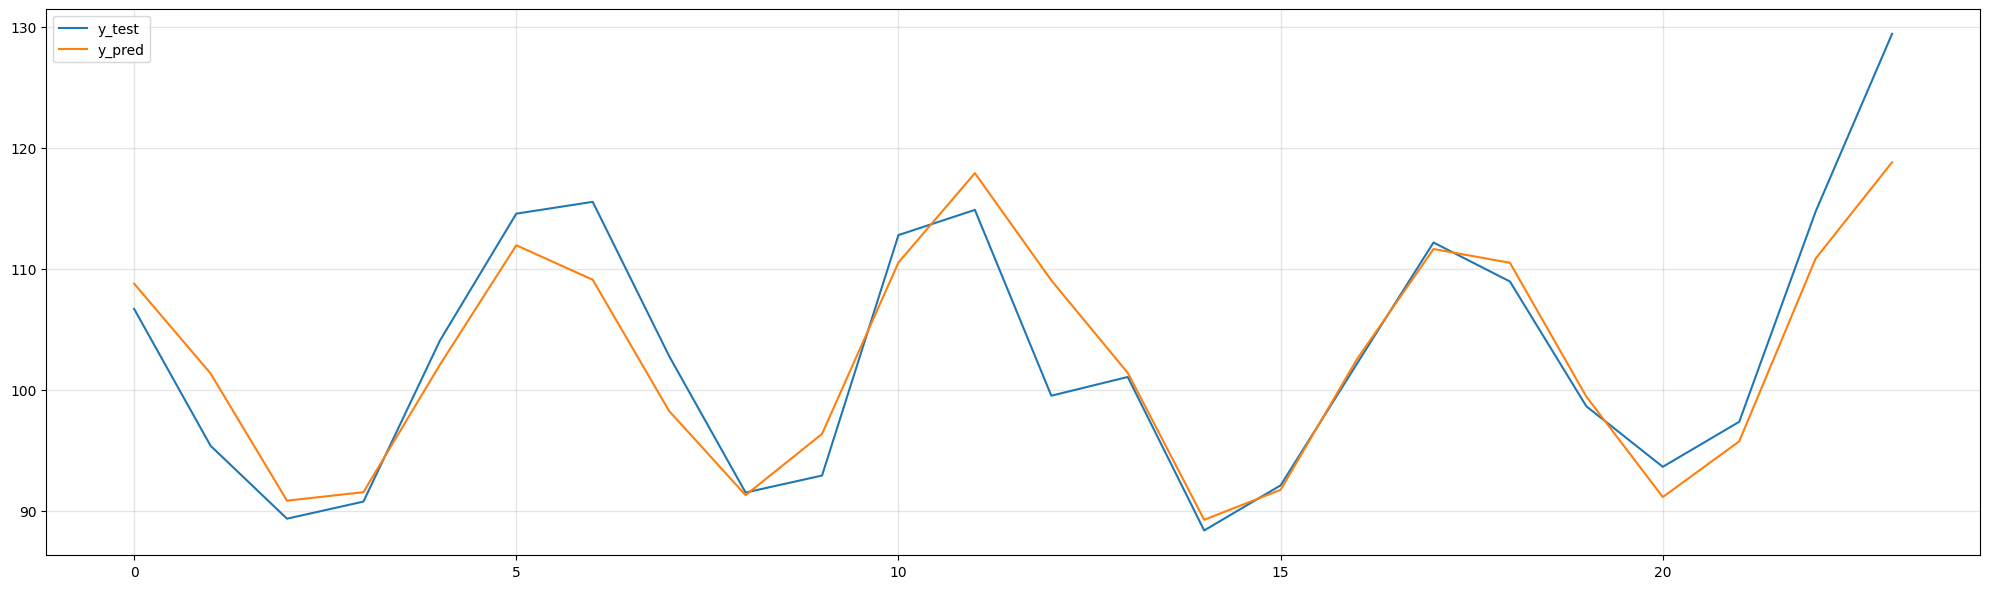

In [9]:
model = StackingRNN(128, 24, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1,
                    stack_num=4, num_layers=1, bidirectional=True, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))

y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

In [10]:
model = StackingRNN(128, 24, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1,
                    stack_num=4, num_layers=1, bidirectional=True, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))

y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

Using cpu backend
Epoch 1/3000  
7/7 - p0 - loss: 0.2073 - mae: 0.2119 - val_loss: 0.1768 - val_mae: 0.1768 - 0.18s/epoch - 0.026s/step
Epoch 2/3000  
7/7 - p1 - loss: 0.2491 - mae: 0.2376 - val_loss: 0.2229 - val_mae: 0.2229 - 0.16s/epoch - 0.023s/step
Epoch 3/3000  
7/7 - p0 - loss: 0.1739 - mae: 0.1601 - val_loss: 0.1687 - val_mae: 0.1687 - 0.18s/epoch - 0.026s/step
Epoch 4/3000  
7/7 - p1 - loss: 0.1813 - mae: 0.1856 - val_loss: 0.1834 - val_mae: 0.1834 - 0.17s/epoch - 0.024s/step
Epoch 5/3000  
7/7 - p2 - loss: 0.2043 - mae: 0.1812 - val_loss: 0.1982 - val_mae: 0.1982 - 0.19s/epoch - 0.027s/step
Epoch 6/3000  
7/7 - p3 - loss: 0.1999 - mae: 0.1729 - val_loss: 0.1926 - val_mae: 0.1926 - 0.18s/epoch - 0.025s/step
Epoch 7/3000  
7/7 - p4 - loss: 0.1919 - mae: 0.1717 - val_loss: 0.1878 - val_mae: 0.1878 - 0.16s/epoch - 0.023s/step
Epoch 8/3000  
7/7 - p5 - loss: 0.1932 - mae: 0.1743 - val_loss: 0.1902 - val_mae: 0.1902 - 0.17s/epoch - 0.025s/step
Epoch 9/3000  
7/7 - p6 - loss: 0.1968

KeyboardInterrupt: 

# GAUNet

Using cpu backend
Epoch 1/3000  
55/55 - p0 - loss: 0.1605 - mae: 0.2696 - val_loss: 0.0907 - val_mae: 0.0907 - 0.26s/epoch - 0.005s/step
Epoch 2/3000  
55/55 - p0 - loss: 0.1435 - mae: 0.1930 - val_loss: 0.0632 - val_mae: 0.0632 - 0.26s/epoch - 0.005s/step
Epoch 3/3000  
55/55 - p0 - loss: 0.1341 - mae: 0.1784 - val_loss: 0.0520 - val_mae: 0.0520 - 0.25s/epoch - 0.005s/step
Epoch 4/3000  
55/55 - p1 - loss: 0.1286 - mae: 0.1698 - val_loss: 0.0544 - val_mae: 0.0544 - 0.26s/epoch - 0.005s/step
Epoch 5/3000  
55/55 - p2 - loss: 0.1215 - mae: 0.1621 - val_loss: 0.0525 - val_mae: 0.0525 - 0.25s/epoch - 0.005s/step
Epoch 6/3000  
55/55 - p0 - loss: 0.1108 - mae: 0.1557 - val_loss: 0.0503 - val_mae: 0.0503 - 0.26s/epoch - 0.005s/step
Epoch 7/3000  
55/55 - p1 - loss: 0.1112 - mae: 0.1520 - val_loss: 0.0511 - val_mae: 0.0511 - 0.25s/epoch - 0.004s/step
Epoch 8/3000  
55/55 - p0 - loss: 0.1032 - mae: 0.1501 - val_loss: 0.0493 - val_mae: 0.0493 - 0.24s/epoch - 0.004s/step
Epoch 9/3000  
55/55 -

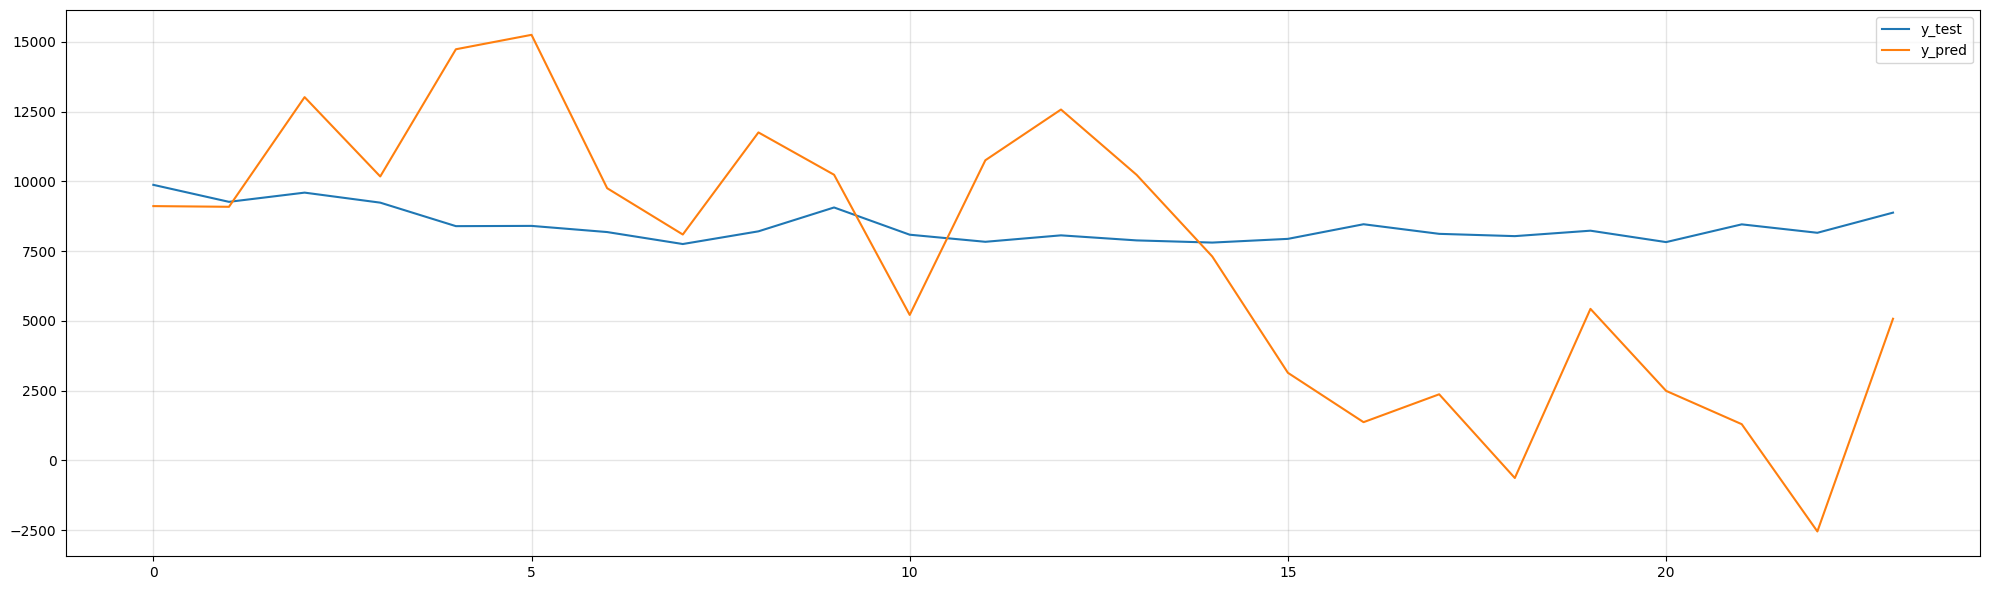

In [9]:
model = GAUNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, level=2, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))
y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# Time2VecNet

r2: 0.8372770385948494
mae: 2.786961499898275
mape: 0.02698903244076549


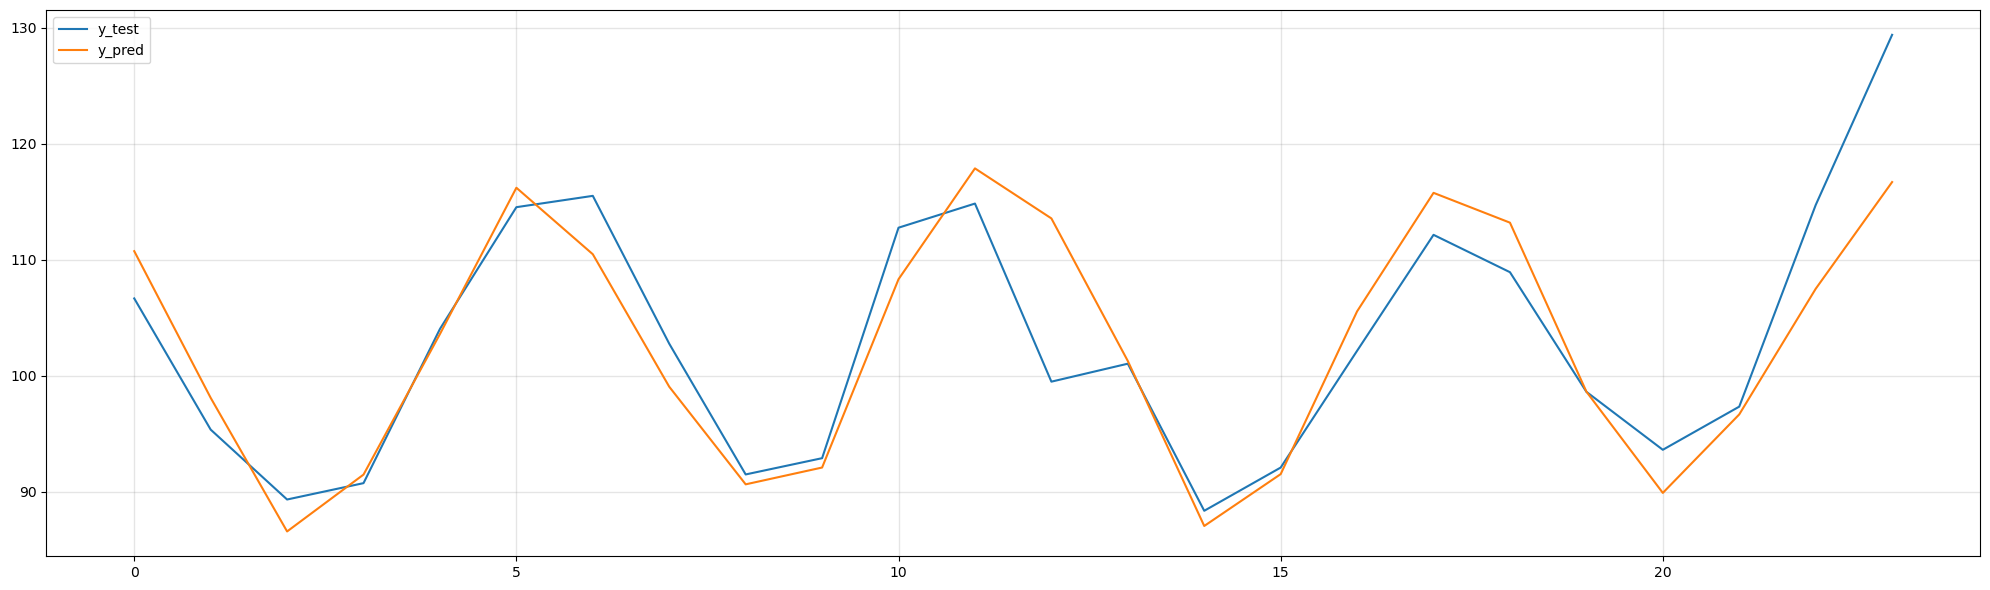

In [9]:
model = Time2VecNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=False, lr_scheduler='ReduceLROnPlateau')

y_pred_inverse = model.predict(x_test)

print(f"r2: {r2_score(y_test.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred_inverse)}")
a = plot2d(y_test, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))